In [1]:
#Import Libraries
from __future__ import print_function, division
import argparse
import os
import time
import utils
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
import random
import torch.nn.functional as F
from torch.optim import lr_scheduler
import copy

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

seed = 7
np.random.seed(seed)
torch.manual_seed(seed)

#using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
class car_dataset(Dataset):
    """
    Description:
        Pytorch Dataset class for reading Car Dataset meta files and images.
    Arguments:
        files (list, required): 
        root_dir (str, required): Root directory path
        meta_data (list, required): exctracted meta data
    Returns a Dictionary
    """
    def __init__(self, files, root_dir, meta_data, image_transform=None):
        
        self.root_dir = root_dir
        self.image_transform = image_transform
        
        #image file names
        self.image_files = [file[-1][0] for file in files]
        
        #Class ID
        self.id = [file[-2][0] - 1 for file in files]
        
        #Class Name
        self.class_name = [meta_data[file[-2][0] - 1][0] for file in files]
        
        #Get Car Year
        self.carYear, self.carYear_ID = utils.get_Year(self.class_name)

        #Get Car Maker
        self.carMaker, self.carMaker_ID = utils.get_Maker(self.class_name)
        
        #Get Car Type
        self.carType, self.carType_ID = utils.get_Type(self.class_name)
        
        #change and Move there is still time
        self.year_count = len(np.unique(self.carYear_ID))
        self.maker_count = len(np.unique(self.carMaker_ID))
        self.type_count = len(np.unique(self.carType_ID))
        
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path)
        
        if self.image_transform:
            img = self.image_transform(img)
        
        target = torch.from_numpy(np.array(self.id[idx]))[0]
        
        class_count = {
                      "year": self.year_count,
                      "maker": self.maker_count,
                      "type": self.type_count
                     }

        sample = {'Image':img, 'class_ID':target, "class_name":self.class_name[idx],
                 'year_ID':self.carYear_ID[idx], 'maker_ID':self.carMaker_ID[idx],
                 'type_ID':self.carType_ID[idx], "class_count":class_count}
        
        return sample

In [3]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset creating
        a weight depeding of the frequency of the class
    Arguments:
        dataset (list, optional): a list of indices
        class_type (int, optional): 
    """
    def __init__(self, dataset, class_type):
                      
        self.indices = list(range(len(dataset)))
        
        self.num_samples = len(self.indices) 
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx, class_type)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx, class_type)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx, class_type):
        return dataset[idx][class_type].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [4]:
root_dir = "data/cars_train/" #folder path of location of training images
car_annotations_path = "data/devkit/cars_train_annos.mat" #Training annotation mat
car_metadata_path = "data/devkit/cars_meta.mat" #meta data mat

#Load Meta Data
meta_data = loadmat(car_metadata_path)
meta_data = np.concatenate(meta_data["class_names"][0])

#nb_classes
nb_classes = len(meta_data)

#Load and split train, val and test samples
dataset = utils.Load_Images(root_dir=root_dir, annotations_path=car_annotations_path, seed=seed, test_split=0.2)

In [5]:
image_transformers = {'training': transforms.Compose([transforms.Resize((224, 224)),
                                                       transforms.RandomRotation(degrees=30),
                                                       transforms.RandomHorizontalFlip(0.8),
                                                       transforms.RandomPerspective(p=0.2),
                                                     transforms.ColorJitter(brightness=0.8, contrast=0.8),
                                                     transforms.ToTensor()]),
                      'validation': transforms.Compose([transforms.Resize((224, 224)),
                                                       transforms.ToTensor()])
                     }
    

training_data = car_dataset(dataset["training"],
                            root_dir = root_dir,
                            meta_data = meta_data,
                            image_transform = image_transformers["training"]
                           )

#
train_loader = torch.utils.data.DataLoader(training_data, batch_size=15,sampler=ImbalancedDatasetSampler(training_data, "class_ID"))

#train_loader = torch.utils.data.DataLoader(training_data, batch_size=15, shuffle=True)

validation_data = car_dataset(dataset["validation"], 
                             root_dir = root_dir,
                             meta_data = meta_data,
                             image_transform  = image_transformers["validation"])

validation_loader = torch.utils.data.DataLoader(validation_data, 
                                                batch_size=15, shuffle=True)

'''
testing_data = car_dataset(dataset["test"], 
                           root_dir = root_dir,
                           meta_data = meta_data,
                           image_transform  = image_transformers["validation"])

test_loader = torch.utils.data.DataLoader(testing_data, batch_size=15, shuffle=True)
'''

dataloaders = {"training":train_loader, "validation":validation_loader}
dataSizes = {"training":len(dataset["training"]), "validation":len(dataset["validation"])}

In [6]:
#Get Count per each Class
class_year = training_data[0]["class_count"]["year"]
class_maker = training_data[0]["class_count"]["maker"]
class_type = training_data[0]["class_count"]["type"]

In [7]:
#Load Pretrained Model
fr_model = torchvision.models.resnet50(pretrained=True)

#freeze layers
for param in fr_model.parameters():
    param.requires_grad = False
    
print(fr_model)
num_ftrs = fr_model.fc.in_features
fr_model.fc = torch.nn.Linear(num_ftrs, 1024)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
class multi_task_model(torch.nn.Module):
    def __init__(self, base_model,nb_maker_classes, nb_type_classes):
        super(multi_task_model, self).__init__()
        
        self.base_model = base_model
        
        self.x1 = torch.nn.Linear(1024, 512)
        torch.nn.init.xavier_normal_(self.x1.weight) 
        self.bn1 = torch.nn.BatchNorm1d(512, eps = 2e-1)
        
        
        #could overfit add, dropout??
        self.x2 = torch.nn.Linear(512,512)
        torch.nn.init.xavier_normal_(self.x2.weight)
        self.bn2 = torch.nn.BatchNorm1d(512, eps = 2e-1)
        
        #adding one more on top of the heads
        self.x3 = torch.nn.Linear(512, 256)
        torch.nn.init.xavier_normal_(self.x3.weight)
        
        #Connect the base Model to each head
        self.y_maker = torch.nn.Linear(256, nb_maker_classes)
        torch.nn.init.xavier_normal_(self.y_maker.weight)
        self.y_type = torch.nn.Linear(256, nb_type_classes)
        torch.nn.init.xavier_normal_(self.y_type.weight)
        
    def forward(self, x):
        
        x1 = self.base_model(x)
        
        x1 = self.bn1(F.relu(self.x1(x1)))
        x1 = self.bn2(F.relu(self.x2(x1)))
        
        y_maker_output = F.softmax(self.y_maker(self.x3(x1)))
        y_type_output = F.softmax(self.y_type(self.x3(x1)))
        
        return y_maker_output, y_type_output

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
MTL_model = multi_task_model(fr_model, class_maker, class_type)
MTL_model = MTL_model.to(device)

print(MTL_model)
print(MTL_model.parameters())   

criterion = torch.nn.CrossEntropyLoss() 

multi_task_model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
        

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    #last recorded best loss
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            year_loss = 0.0
            type_loss = 0.0
            maker_loss = 0.0

            correct_year = 0.0
            correct_maker = 0.0
            correct_type = 0.0
            
            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                
                inputs = data["Image"].to(device)
                
                maker_labels = data["maker_ID"].to(device)
                type_labels = data["type_ID"].to(device)
            
                optimizer.zero_grad()
                
                #set to true when training
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    
                    #Order: maker, type
                    loss_maker = criterion(outputs[0], maker_labels.long())
                    loss_type = criterion(outputs[1], type_labels.long())
                    
                    if phase == 'training':
                        
                        #take sum of all loses
                        total_loss = loss_maker + loss_type
                        
                        total_loss.backward()
                        optimizer.step()
                        
                running_loss += total_loss.item() * inputs.size(0)
                
                type_loss += loss_maker.item() * inputs.size(0)
                maker_loss += loss_type.item() * inputs.size(0)    
                
                correct_counts_maker = torch.max(outputs[0], dim=1)[1].eq(maker_labels.data.view_as(torch.max(outputs[0], dim=1)[1]))
                correct_counts_type = torch.max(outputs[1], dim=1)[1].eq(type_labels.data.view_as(torch.max(outputs[1], dim=1)[1]))
                
                acc_m = torch.mean(correct_counts_maker.type(torch.FloatTensor))
                acc_t = torch.mean(correct_counts_type.type(torch.FloatTensor))
                
                correct_maker += acc_m.item() * inputs.size(0)
                correct_type += acc_t.item() * inputs.size(0)
                

                      
            step_loss = running_loss / dataSizes[phase]
            
            maker_loss_total = maker_loss / dataSizes[phase]
            type_loss_total = type_loss / dataSizes[phase]

            maker_acc = correct_maker / dataSizes[phase]
            type_acc = correct_type / dataSizes[phase]
            
            print('{} total loss: {:.4f}'.format(phase, step_loss))
            print('{} Maker_acc: {:.2f}  Type_acc: {:.2f}'.format(phase, maker_acc, type_acc))
            print('{} Maker_loss: {:.2f}  Type_loss: {:.2f}'.format(phase,maker_loss_total,type_loss_total))
            history.append([epoch, step_loss, maker_loss_total, type_loss_total, maker_acc, type_acc])
            
            # testing stuff
            if phase == 'validation' and maker_acc > best_val_acc:
                print('saving with acc of {}'.format(maker_acc))
                best_val_acc = maker_acc
                #save these weights
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    last_model_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model, last_model_weights, history

In [11]:
#To Do: Create a LR finder
lrhead = .001 #learning rate for heads
lrmain = .0001

optimizers = torch.optim.Adam(
    [
        {"params":MTL_model.base_model.parameters(),"lr": lrmain},
        {"params":MTL_model.x1.parameters(), "lr": lrhead},
        {"params":MTL_model.x2.parameters(), "lr": lrhead},
        {"params":MTL_model.y_maker.parameters(), "lr": lrhead},
        {"params":MTL_model.y_type.parameters(), "lr": lrhead}  
   ])

optimizer_ft = optimizers

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
#my last
trained_model, l_model, history = train_model(MTL_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
------------------------------


C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


training total loss: 6.1263
training Maker_acc: 0.11  Type_acc: 0.32
training Maker_loss: 2.30  Type_loss: 3.82
validation total loss: 6.4468
validation Maker_acc: 0.15  Type_acc: 0.45
validation Maker_loss: 2.17  Type_loss: 3.77
saving with acc of 0.1542247804806211
Epoch 1/29
------------------------------
training total loss: 6.0355
training Maker_acc: 0.14  Type_acc: 0.37
training Maker_loss: 2.25  Type_loss: 3.79
validation total loss: 6.0213
validation Maker_acc: 0.16  Type_acc: 0.46
validation Maker_loss: 2.16  Type_loss: 3.77
saving with acc of 0.15996719217745373
Epoch 2/29
------------------------------
training total loss: 5.9916
training Maker_acc: 0.16  Type_acc: 0.39
training Maker_loss: 2.23  Type_loss: 3.76
validation total loss: 5.7347
validation Maker_acc: 0.16  Type_acc: 0.47
validation Maker_loss: 2.14  Type_loss: 3.77
Epoch 3/29
------------------------------
training total loss: 5.9781
training Maker_acc: 0.16  Type_acc: 0.40
training Maker_loss: 2.22  Type_loss: 

training total loss: 5.8966
training Maker_acc: 0.19  Type_acc: 0.45
training Maker_loss: 2.16  Type_loss: 3.73
validation total loss: 6.3351
validation Maker_acc: 0.21  Type_acc: 0.55
validation Maker_loss: 2.07  Type_loss: 3.72
saving with acc of 0.2116488989463979
Training complete in 73m 15s


In [13]:
#save them weights
torch.save(trained_model.state_dict(), 'MTL_weights.pth')

In [14]:

fr_model = torchvision.models.resnet50(pretrained=True)

#Load Model weights
for param in fr_model.parameters():
    param.requires_grad = False

num_ftrs = fr_model.fc.in_features
fr_model.fc = torch.nn.Linear(num_ftrs, 1024)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MTL_model = multi_task_model(fr_model, class_maker, class_type)
MTL_model = MTL_model.to(device)

MTL_model.load_state_dict(torch.load('MTL_weights_10.pth'))
MTL_model.eval()

multi_task_model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
        

In [15]:
car_types = ["Coupe", "Sedan", "Cab",
             "Beetle", "SUV", "Van",
             "SuperCab", "Convertible",
             "Minivan", "Hatchback",
             "Wagon", "no_type"]

makers = ["AM General Hummer", "Acura", "Aston Martin", "Audi" , "BMW", "Bentley", "Bugatti Veyron 16.4","Buick","Cadillac",
         "Chevrolet", "Chrysler", "Daewoo", "Dodge", "Eagle Talon", "FIAT", "Ferrari", "Ford", "GMC", "Geo Metro Convertible", 
         "HUMMER", "Honda", "Hyundai", "Infiniti", "Isuzu Ascender", "Jaguar", "Jeep", "Lamborghini", "Land Rover", 
         "Lincoln Town Car", "MINI Cooper Roadster", "Maybach Landaulet", "Mazda Tribute", "McLaren MP4-12C", "Mercedes-Benz", 
         "Mitsubishi Lancer","Nissan", "Plymouth Neon", "Porsche Panamera", "Ram C/V", "Rolls-Royce", "Scion", "Spyker", "Suzuki", 
         "Tesla", "Toyota", "Volkswagen", "Volvo", "smart fortwo", "Fisker Karma Sedan"]

def extract_label(label_list, pred_array, top_n=1):
    pred_max = torch.topk(pred_array,top_n)[1]    
    out_list = []
    for i in pred_max[0]:
        out_list.append(label_list[i])
    return out_list

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = image_transformers["validation"](image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0) 
    return image.cuda() #make sure you are use gpu

Classified Maker: ['Audi'], Classified Type: ['Convertible']


C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


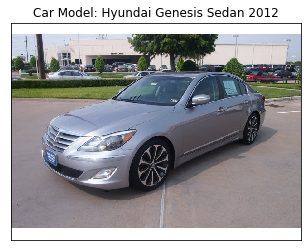

Classified Maker: ['GMC'], Classified Type: ['SuperCab']


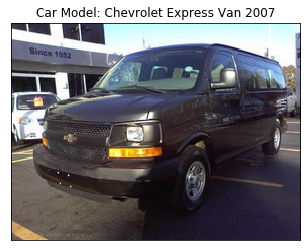

Classified Maker: ['Chevrolet'], Classified Type: ['SuperCab']


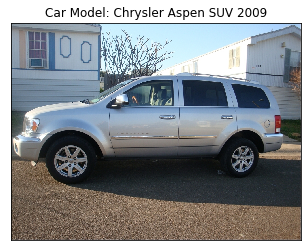

In [19]:
#Sanity check
#Classify a few images in the testset
for image_file in dataset["test"][10:13]:
    file_path = os.path.join(root_dir,image_file[-1][0])
    img = image_loader(file_path)
    
    output = MTL_model(img)
    print("Classified Maker: {}, Classified Type: {}".format(extract_label(makers, output[0]), 
                                                            extract_label(car_types, output[1])))
    pil_im = Image.open(file_path)
    plt.imshow(np.asarray(pil_im))
    plt.title("Car Model: {}".format(meta_data[image_file[-2][0][0]-1]))
    plt.show()

In [20]:
#get labels of testing set
y_labels = [meta_data[label[-2][0][0]-1] for label in  dataset["test"]]
y_type_labels, y_type = utils.get_Type(y_labels)
y_maker_labels, y_maker = utils.get_Maker(y_labels)

In [21]:

#get classification
yhat_type = []
yhat_maker = []
type_preds = []
maker_preds = []
for image_file in dataset["test"]:
    file_path = os.path.join(root_dir,image_file[-1][0])
    img = image_loader(file_path)
    
    output = MTL_model(img)
    #actuald
    type_preds.append(output[0][0].cpu().detach().numpy())
    yhat_maker.append(extract_label(makers, output[0])[0])
    yhat_type.append(extract_label(car_types, output[1])[0])

C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


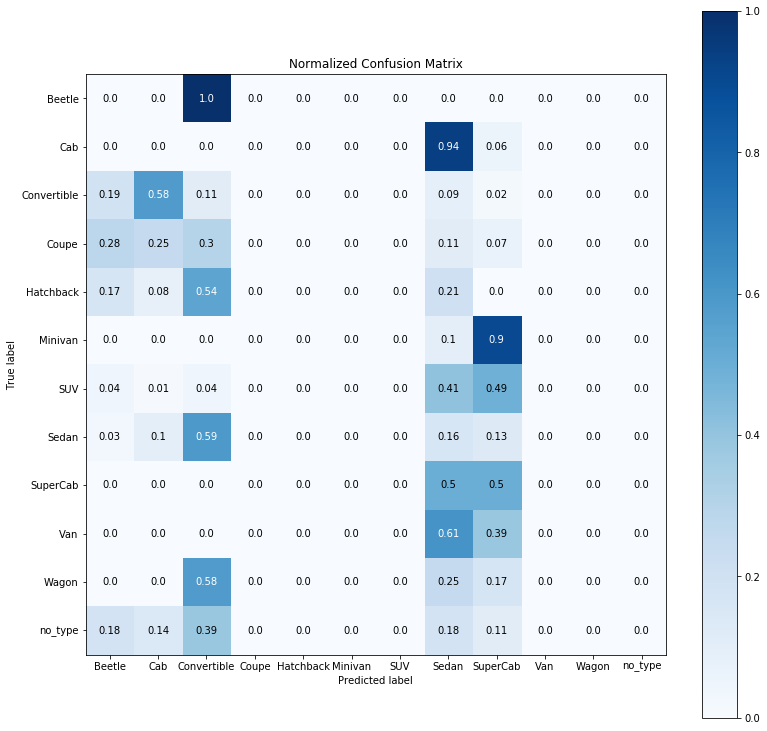

In [24]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_type_labels, yhat_type, normalize=True,figsize=(13,13))

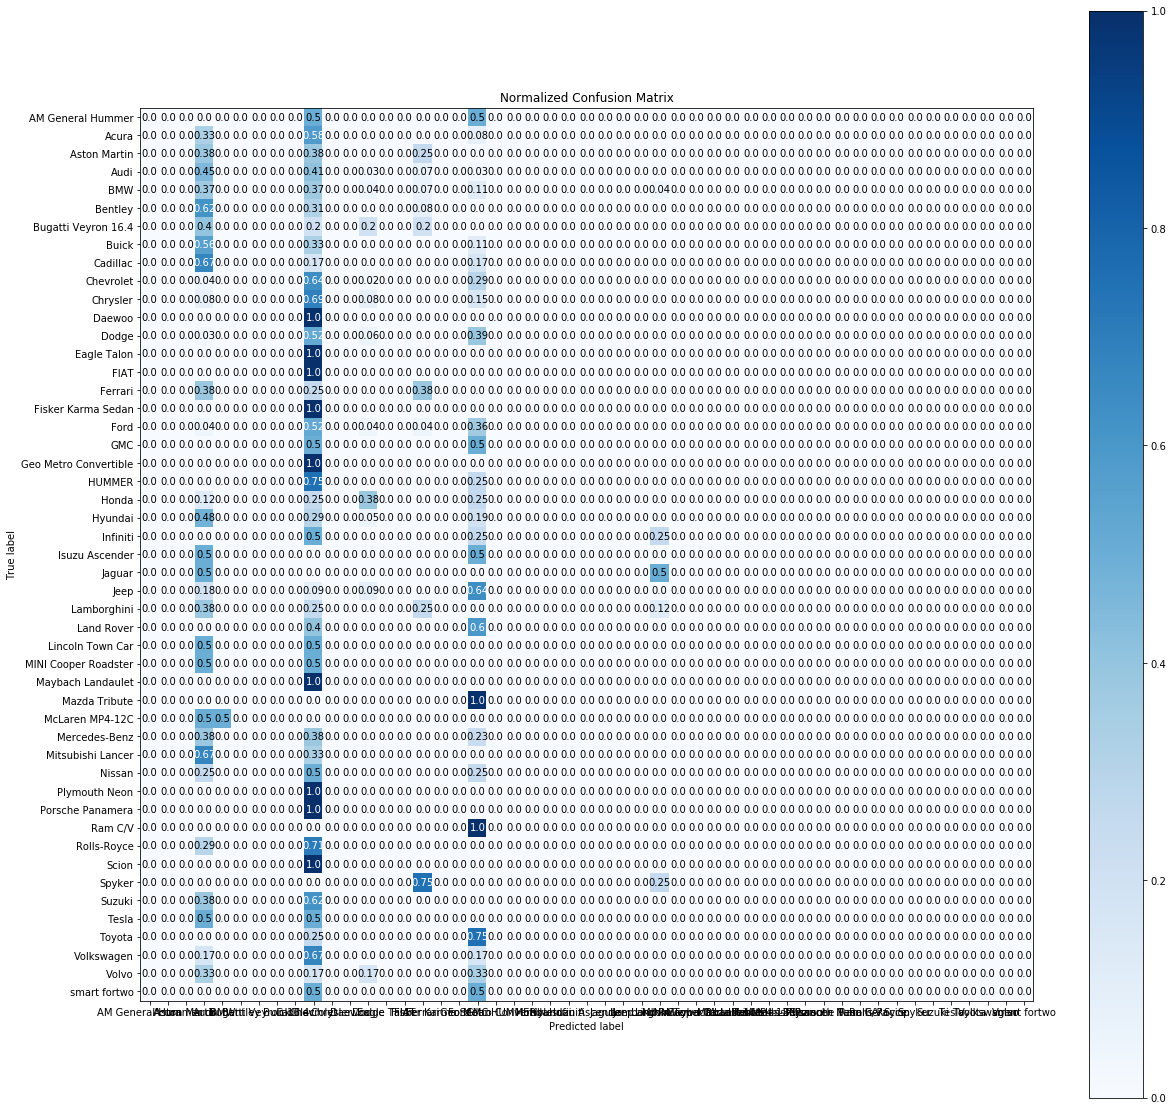

In [25]:
skplt.metrics.plot_confusion_matrix(y_maker_labels, yhat_maker, normalize=True,figsize=(20,20))

## Testing on your own images

In [26]:
def Classify_Image(image_path, model):
    '''
    Arguments:
        Image Path
        Torch Model
    Output:
        Car Maker probabilities
        Car type probabilities
    '''
    img = image_loader(image_path)
    
    output = model(img)
    
    return output[0], output[1]

C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


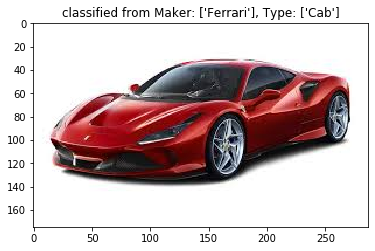

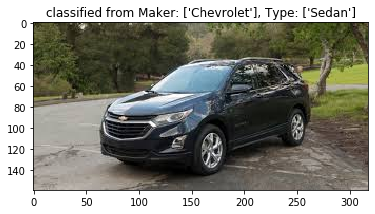

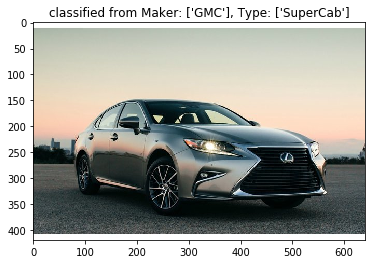

In [34]:
from os import listdir
from os.path import isfile, join

test_image_folder = "test_images/" #location of testing images I got from the internet

image_files = [os.path.join(f) for f in listdir(test_image_folder) if isfile(join(test_image_folder, f))]

for image_path in image_files:
    
    #get car maker and car
    carmaker, cartype = Classify_Image(os.path.join(test_image_folder, image_path), MTL_model)
    
    im = Image.open(os.path.join(test_image_folder, image_path))
    plt.imshow(np.asarray(im))
    plt.title("classified from Maker: {}, Type: {}".format(extract_label(makers,carmaker),
                                                           extract_label(car_types,cartype)))
    plt.show()